In [1]:
from pylab import *  
import numpy as np

In [2]:
#--- precipitable water vapor (g/cm2)
uw = [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0, 3.25, 3.5, 3.75, 4.0]

#--- surface skin temperature (K)
temps = [270, 275, 280, 285, 290, 295, 300]

#--- folder path
folder = 'figure/'

In [3]:
def read_sbdart_data(filename):
    f_raw = loadtxt(filename,delimiter="\t",skiprows=3,dtype='str')
    f = f_raw[::3]

    WL=[] #--- wavelength (um)
    FFV=[] #--- filter value
    TOPDN=[] #--- downwelling flux to the top of the atmosphere (TOA, W/cm2/um)
    TOPUP=[] #--- TOA upwelling flux
    TOPDIR=[] #--- TOA direct flux
    BOTDN=[] #--- downwelling flux at surface
    BOTUP=[] #--- upwelling flux at surface
    BOTDIR=[] #--- direct flux at surface

    for row in f:
        row = row[1:]
        row = row.replace('  ',' ')
        row = row.lstrip()
        split_row = row.split(' ')
        #print(split_row)
    
        WL.append(float(split_row[0]))
        FFV.append(float(split_row[1]))
        TOPDN.append(float(split_row[2]))
        TOPUP.append(float(split_row[3]))
        TOPDIR.append(float(split_row[4]))
        BOTDN.append(float(split_row[5]))
        BOTUP.append(float(split_row[6]))
        BOTDIR.append(float(split_row[7]))

    return TOPUP

In [4]:
flux_lw_290 = read_sbdart_data(folder+'11um_290')
flux_sw_290 = read_sbdart_data(folder+'39um_290')

In [5]:
flux_lw_290

[25.567,
 25.63,
 25.55,
 25.441,
 25.307,
 25.15,
 24.973,
 24.779,
 24.571,
 24.354,
 24.128,
 23.898,
 23.665,
 23.432,
 23.198,
 22.967,
 22.739]

In [6]:
flux_sw_290

[1.1213,
 1.1182,
 1.1154,
 1.1126,
 1.1097,
 1.1069,
 1.1039,
 1.101,
 1.098,
 1.095,
 1.092,
 1.089,
 1.0859,
 1.0828,
 1.0796,
 1.0764,
 1.0732]

#### Calculate the brightness temperature difference: 

* sbdart gives the flux density in w/m2/micron
* this can be easily converted to brightness temperature ($T_B$) with an inversion of Planck's equation: 
    * $\lambda$: wavelength
    * $\Omega$: beam solid angle
    * $S$: flux density
 
$$
T_b = \frac{c_2}{\lambda \text{ ln}(\frac{c_1}{\lambda^5 S}+1)}
$$

In [7]:
def flux_to_Tb(flux, wl):
    c1 = 3.74e-22
    c2 = 0.0144
    S = np.array(flux) #W m-2 um-1
    
    T_b = c2/(wl*np.log((c1/((wl**5)*S)+1)))
    
    return T_b

In [8]:
data = {}

for t in temps:
    flux_lw = read_sbdart_data(folder+'11um_'+str(t))
    flux_sw = read_sbdart_data(folder+'39um_'+str(t))
    
    
    BTD = flux_to_Tb(flux_lw, 11e-6) - flux_to_Tb(flux_sw, 3.9e-6)
    #print(BTD)

    for i in range(len(uw)):
        data[t, uw[i]] = BTD[i]

data

{(270, 0.0): -0.10228614526283764,
 (270, 0.25): 0.02549584347286782,
 (270, 0.5): 0.1538661978397613,
 (270, 0.75): 0.35598045644672993,
 (270, 1.0): 0.6197203410561656,
 (270, 1.25): 0.928800864058644,
 (270, 1.5): 1.268722292328448,
 (270, 1.75): 1.6214352210890297,
 (270, 2.0): 1.971309095816423,
 (270, 2.25): 2.307505490597862,
 (270, 2.5): 2.624376494202693,
 (270, 2.75): 2.910157524580427,
 (270, 3.0): 3.16020510931628,
 (270, 3.25): 3.374062429056835,
 (270, 3.5): 3.5495604893352493,
 (270, 3.75): 3.687375113017879,
 (270, 4.0): 3.786941445081368,
 (275, 0.0): 0.46354079552986605,
 (275, 0.25): 0.6181036761670384,
 (275, 0.5): 0.6769670559687029,
 (275, 0.75): 0.7753160399071248,
 (275, 1.0): 0.9019766295443219,
 (275, 1.25): 1.044785342882733,
 (275, 1.5): 1.1983340414420809,
 (275, 1.75): 1.3512509462474327,
 (275, 2.0): 1.4954078893152314,
 (275, 2.25): 1.6248696649932413,
 (275, 2.5): 1.7312555753342167,
 (275, 2.75): 1.8178072627853226,
 (275, 3.0): 1.8758188069762127,
 (2

In [9]:
x_values, y_values, values = zip(*[(x, y, value) for (x, y), value in data.items()])

In [10]:
btd_grid = np.array(values).reshape(len(temps), len(uw))
uw_grid, temp_grid = np.meshgrid(uw, temps)

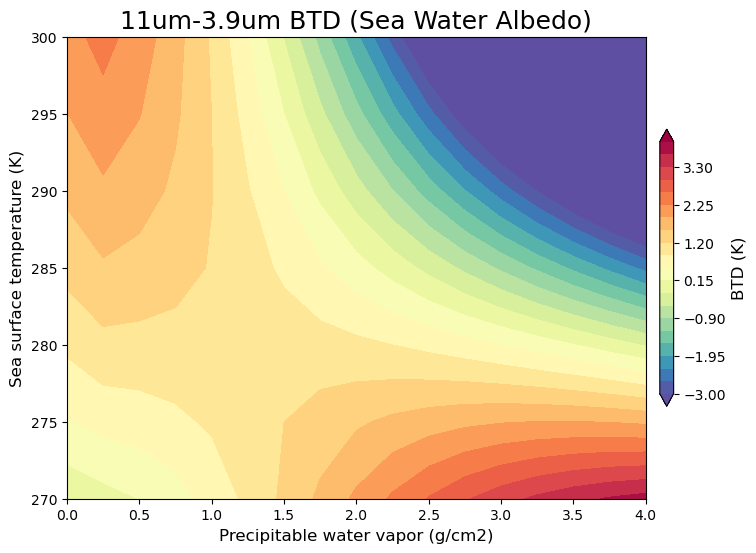

In [11]:
fig,ax=plt.subplots(1, figsize=(9,6))
cmap = plt.cm.Spectral_r
levels = np.linspace(-3, 4, 21)

c=ax.contourf(uw_grid, temp_grid, btd_grid, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.6, pad=0.02, ax=ax)
ax.set_title('11um-3.9um BTD (Sea Water Albedo)', fontsize=18)
ax.set_ylabel('Sea surface temperature (K)', fontsize=12)
ax.set_xlabel('Precipitable water vapor (g/cm2)', fontsize=12)
clb.set_label('BTD (K)', fontsize=12)
plt.savefig('sbdart_sst_wv.png', dpi=200, bbox_inches='tight')